In [61]:
#케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구 알아보기

In [73]:
#패션 MNIST 데이터셋 적재 후 훈련 세트와 검증 세트로 나누기
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [75]:
#모델 만들기 -> 모델을 만드는 간단한 함수를 정의해보았다.
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer: #a_layer 매개변수로 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 구문
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [77]:
model = model_fn()

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=5, verbose=0) #verbose=0 -> 훈련 과정을 나타내지 않는다.
#fit() 메서드의 결과를 history 변수에 담아보았다.

In [81]:
print(history.history.keys()) #history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있다.

dict_keys(['accuracy', 'loss'])


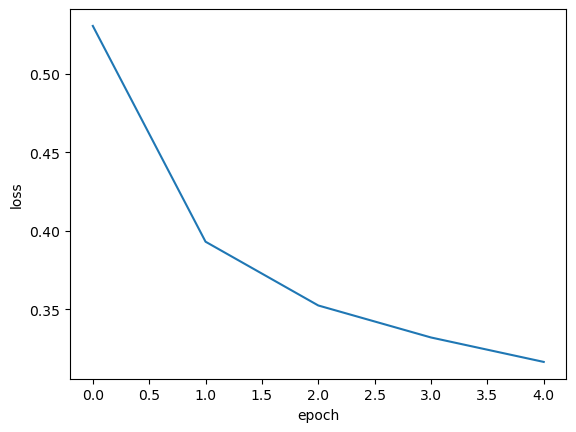

In [83]:
#손실 그래프
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

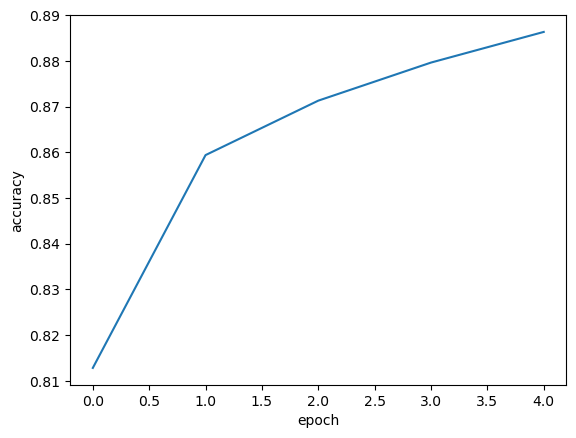

In [85]:
#정확도 그래프
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [87]:
#에포크마다 손실이 감소하고 정확도가 향상한다.
#에포크를 20으로 늘려서 모델을 훈련하고 손실 그래프 그려보기


model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

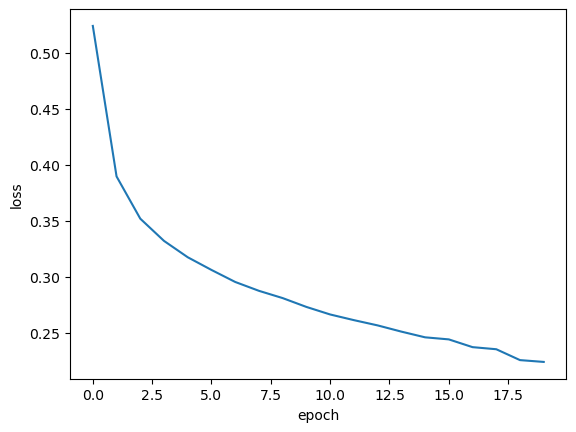

In [89]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#손실이 잘 감소함을 확인할 수 있다.

In [91]:
#검증 손실 계산하기
#케라스 모델의 fit() 메서드에 검증 데이터 전달
#validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [93]:
#검증 세트에 대한 손실과 정확도는 val_loss, val_accuracy에 들어 있다.
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


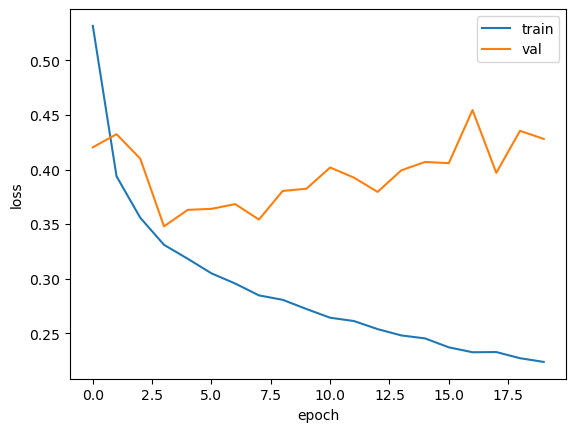

In [95]:
#과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려서 비교
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [97]:
#초기에 검증 손실이 감소하다가 다섯 번째 에포크 만에 다시 상승하기 시작한다.
#훈련 손실은 꾸준히 감소하고 있기 때문에 전형적인 과대적합 모델이 만들어진다.

In [99]:
#Adam 옵티마이저를 사용하여 과대적합 완화시켜보기
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

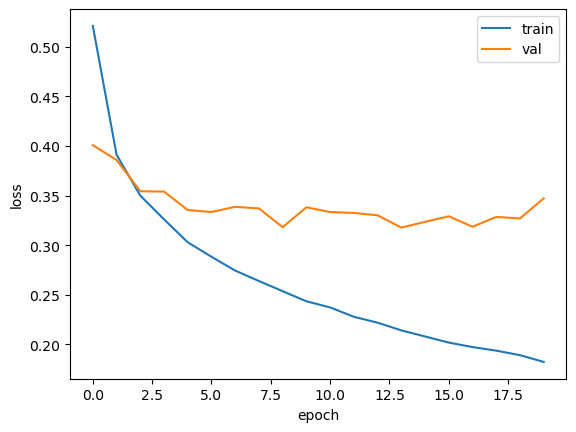

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [103]:
#과대적합이 훨씬 줄었음을 알 수 있다. 열 번째 에포크까지 전반적인 감소 추세 !

In [105]:
#드롭아웃 : 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는다.
#특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야하기 때문이다.

model = model_fn(keras.layers.Dropout(0.3)) #30% 정도를 드롭아웃

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
#드롭아웃층은 훈련되는 모델 파라미터가 없다. 또한 입력과 출력의 크기가 같다.

In [109]:
#훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다.
#텐서플로나 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않기 때문에 별다른 조치를 취하지 않아도 된다.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

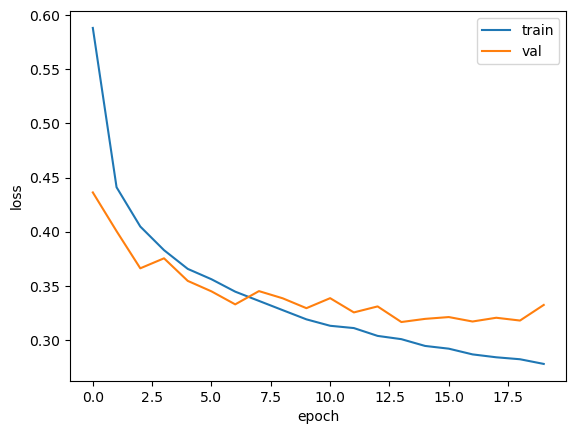

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#드롭아웃 덕분에 과대적합이 확실히 줄었음을 알 수 있다.

In [113]:
#과대적합을 막기 위해 에포크를 다시 10번으로 !
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [115]:
model.save('model-whole.keras') #모델 저장

In [117]:
model.save_weights('model.weights.h5') #훈련된 모델의 파라미터만 저장

In [119]:
!ls -al model* #두 파일이 잘 만들어졌는지 확인

-rw-r--r--  1 sumink  staff  979391 Mar 30 12:47 model-whole.keras
-rw-r--r--  1 sumink  staff  976600 Mar 30 12:48 model.weights.h5


In [121]:
#훈련하지 않은 새로운 모델 만들고 저장했던 모델 파라미터 적재하기
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model.weights.h5')

In [123]:
#모델의 검증 정확도 확인
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
0.8799166666666667


In [129]:
#모델 전체를 파일에서 읽은 다음 검증 세트의 정확도 출력
model = keras.models.load_model('model-whole.keras')

model.evaluate(val_scaled, val_target)
#같은 모델을 저장하고 다시 불러들였기 때문에 위와 동일한 정확도이다.

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8806 - loss: 0.3309


[0.3325709402561188, 0.8799166679382324]

In [131]:
#콜백 - 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', #기본적으로 에포크마다 모델을 저장
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [133]:
#가장 낮은 검증 손실 모델을 자동으로 저장해준다.
model = keras.models.load_model('best-model.keras')

model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.8887 - loss: 0.3057


[0.3093681037425995, 0.8887500166893005]

In [135]:
#과대적합이 시작되기 전에 훈련을 미리 종료하는 것 -> 조기 종료
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, #검증 점수가 향상되지 않더라도 참을 에포크 횟수
                                                  restore_best_weights=True) #가장 낮은 검증 손실을 낸 모델 파라미터를 되돌린다.

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [137]:
print(early_stopping_cb.stopped_epoch) #몇 번째 에포크에서 훈련이 중지되었는지 -> 결과가 책과 다를 수 있ㄷ

8


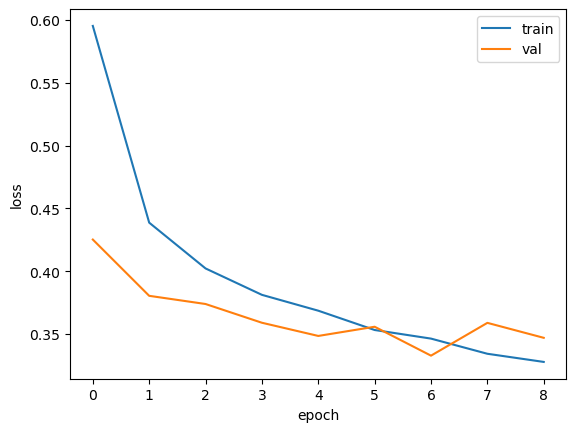

In [139]:
#훈련 손실과 검증 손실 출력 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [59]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.8866 - loss: 0.3148


[0.3164632320404053, 0.8865833282470703]